# Imports

In [1]:
# Python standard library
import sys
import csv

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import rp_file
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

# Load data

In [2]:
date = '7-17-2017/'
particle = '293-T/'
channel = '15-30-15_1/'
file_index = '0'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events.json'

In [3]:
# Load video
oi_vid = oi_file.Video(oi_vid_file_path, 512, 288, 100000)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


# Load template and create stage

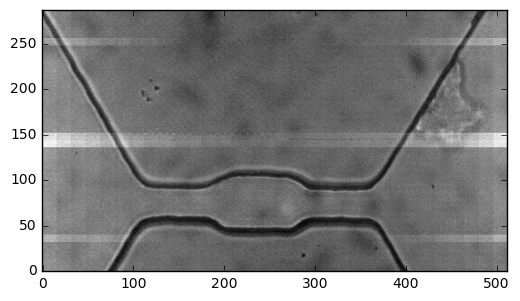

In [4]:
template_index = 0

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

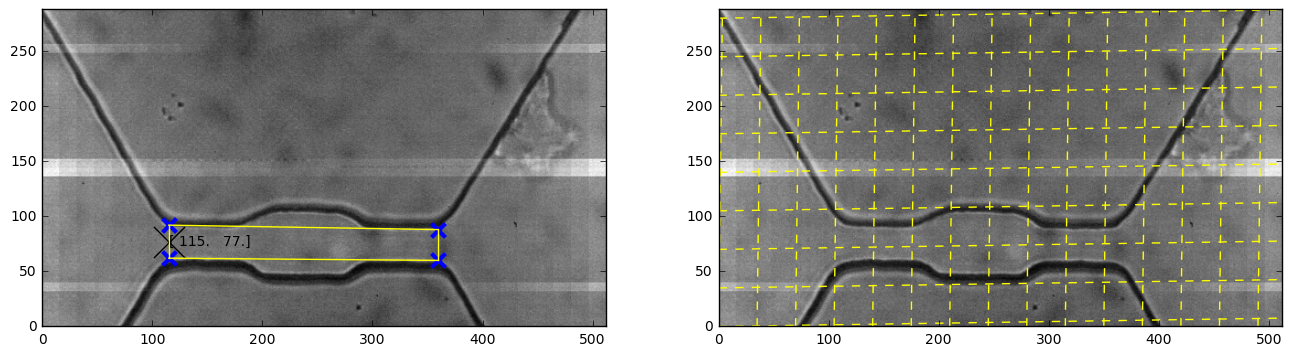

In [5]:
reload(oi)
template_index = 0
template_frame = oi_vid.get_frame(template_index)
c0 = [115,92]
c1 = [115,62]
c2 = [360,60]
c3 = [360,88]
oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

# Define plotting functions

In [6]:
def plot_frame(frame, show = True):
    plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
    
    if show:
        plt.show()
    
def plot_processed_over_raw(processed_frame, frame, show = True):
    green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
    green_processed_frame[:,:,1] = processed_frame

    plt.imshow(frame, cmap = 'gray', origin = 'lower', alpha = 1, interpolation = 'none')
    plt.imshow(green_processed_frame, cmap = 'gray', origin = 'lower', alpha = 0.15, interpolation = 'none')

    if show:
        plt.show()
    
def plot_frame_hist(frame, show = True):
    plt.hist(frame.flatten(), facecolor = 'k', bins = 100)
    
    if show:
        plt.show()
    
def plot_all(processed_frame, frame):
    fig, axes = plt.subplots(1,3,figsize = (12,3))
    
    # Plot 1
    plt.sca(axes[0])
    plot_frame(processed_frame, show = False)
    
    
    # Plot 2
    plt.sca(axes[1])
    plot_processed_over_raw(processed_frame, frame, show = False)
    
    # Plot 3
    plt.sca(axes[2])
    plot_frame_hist(processed_frame, show = False)
    
    plt.show()

# Define ellipse fitting functions

In [7]:
def crop_frame(frame, px, py, crop_distance):    
    x0 = int(px - crop_distance)
    x1 = int(px + crop_distance)
    y0 = int(py - crop_distance)
    y1 = int(py + crop_distance)
    cropped_frame = np.copy(frame)[y0:y1, x0:x1]
    
    return cropped_frame
    

    
    
    
    
    

preprocessing_steps = []
def preprocess_frame(frame, template_frame, detection, debug = 'none'):

    # Refresh list
    del preprocessing_steps[:]

    

    #################################
    # Copy
    #################################
    
    
    
    preprocessing_steps.append(['copy'])

    processed_frame = np.copy(frame)

    if debug == 'all':
        print 'copy'
        plot_all(processed_frame, frame)


    #################################
    # Negative
    #################################



    preprocessing_steps.append(['negative'])

    processed_frame = np.abs(frame - template_frame)


    if debug == 'all':
        print 'negative'
        plot_all(processed_frame, frame)




    #################################
    # Blur
    #################################


    blur_kernel = (3,3)
    preprocessing_steps.append(['gaussian blur', blur_kernel])

    processed_frame = cv2.GaussianBlur(processed_frame, blur_kernel, 0)



    if debug == 'all':
        print 'gaussian blur'
        plot_all(processed_frame, frame)





    #################################
    # Rescale
    #################################

    preprocessing_steps.append(['rescale'])

    processed_frame = (processed_frame - np.min(processed_frame))/(np.max(processed_frame) - np.min(processed_frame))



    if debug == 'all':
        print 'rescale'
        plot_all(processed_frame, frame)






    #################################
    # Threshold
    #################################

    threshold = .125
    preprocessing_steps.append(['pixel intensity threshold', threshold])


    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0




    if debug == 'all':
        print 'threshold'
        plot_all(processed_frame, frame)




    #################################
    # Erode subtraction
    #################################
    iterations = 1
    preprocessing_steps.append(['erode subtraction, iterations = ', iterations])


    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)




    if debug == 'all':
        print 'erode subtraction'
        plot_all(processed_frame, frame)




    #################################
    # Fill holes
    #################################
    preprocessing_steps.append(['fill holes'])

    processed_frame = scipy.ndimage.binary_fill_holes(processed_frame)




    if debug == 'all':
        print 'fill holes'
        plot_all(processed_frame, frame)

    #################################    
    # Get largest cluster
    #################################

    preprocessing_steps.append(['clustering'])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)
    largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for pixel in largest_cluster:
        processed_frame[pixel[0], pixel[1]] = 1





    if debug == 'all':
        print 'cluster'
        plot_all(processed_frame, frame)


    #################################
    # Morphological closing
    #################################

    morph_kernel_size = (10,10)
    preprocessing_steps.append(['morphological closing, kernel = ', morph_kernel_size])

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
    processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)


    if debug == 'all':
        print 'morphological closing'
        plot_all(processed_frame, frame)




    #################################
    # Erode subtraction
    #################################

    iterations = 3
    preprocessing_steps.append(['erosion subtraction, iterations = ', iterations])



    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = iterations)


    if debug == 'all':
        print 'erode subtraction'
        plot_all(processed_frame, frame)
        
        
        
    
    if debug == 'last':
        plot_all(processed_frame, frame)
        
        
    return processed_frame



def fit_ellipse(processed_frame, debug = False):

    #################################
    # Fit ellipse
    #################################



    cell_pixels = np.where(processed_frame == 1)

    ellipse = oi.fit_ellipse(cell_pixels[0], cell_pixels[1])
    
    
    if debug:
        ellipse_center = oi.get_ellipse_center(ellipse)
        ellipse_angle = oi.get_ellipse_angle(ellipse)
        ellipse_axes = oi.get_ellipse_axes_lengths(ellipse)





        ellipse_points = np.empty((100,2))
        for i in range(100):
            angle = i*2*np.pi/99.
            x = ellipse_axes[0]*np.cos(angle)
            y = ellipse_axes[1]*np.sin(angle)
            ellipse_points[i,1] = ellipse_center[0] + np.cos(ellipse_angle)*x - np.sin(ellipse_angle)*y
            ellipse_points[i,0] = ellipse_center[1] + np.sin(ellipse_angle)*x + np.cos(ellipse_angle)*y


        green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
        green_processed_frame[:,:,1] = processed_frame



        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
        plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 0.5, c = 'yellow')

        plt.xlim(0, frame.shape[1])
        plt.ylim(0, frame.shape[0])

        plt.show()
        
    return ellipse



# Fit ellipse to all detections

In [8]:
ellipsess = []
detection_indicess = []


for i, oi_event in enumerate(oi_events):
    print 'event', i, '/', len(oi_events)
    
    
    ellipsess.append([])
    detection_indicess.append([])
    
    
    for j, detection in enumerate(oi_event._detections):
        
        try:

            # Get raw frame
            raw_frame = oi_vid.get_frame(detection._tf)


            # Crop frames
            crop_distance = 30    # Crop frame +/- crop distance from center of event
            cropped_frame = crop_frame(raw_frame, detection._px, detection._py, crop_distance)
            cropped_template_frame = crop_frame(template_frame, detection._px, detection._py, crop_distance)

            
            # Preprocess frame
            processed_frame = preprocess_frame(cropped_frame, cropped_template_frame, detection, debug = 'none')

            
            # Get ellipse + parameters
            ellipse = fit_ellipse(processed_frame)
            ellipse_axes = oi.get_ellipse_axes_lengths(ellipse)
            ellipse_center = oi.get_ellipse_center(ellipse)
            ellipse_center[0] = ellipse_center[0] + (detection._px - crop_distance)
            ellipse_center[1] = ellipse_center[1] + (detection._py - crop_distance)
            
            ellipse_angle = oi.get_ellipse_angle(ellipse)
            
            ellipsess[-1].append([j, ellipse_center[0], ellipse_center[1], ellipse_axes[0], ellipse_axes[1], ellipse_angle])

            
        except:
            
            print '\tfailed on', j, '/', len(oi_event._detections)

event 0 / 150
	failed on 0 / 131
	failed on 1 / 131
	failed on 2 / 131
	failed on 3 / 131
	failed on 4 / 131
	failed on 5 / 131
	failed on 6 / 131
	failed on 7 / 131
	failed on 8 / 131
	failed on 9 / 131
	failed on 10 / 131
	failed on 11 / 131
	failed on 12 / 131
	failed on 13 / 131
	failed on 14 / 131
	failed on 15 / 131
	failed on 16 / 131
	failed on 17 / 131
	failed on 18 / 131
	failed on 19 / 131
event 1 / 150
	failed on 0 / 170
	failed on 1 / 170
	failed on 2 / 170
	failed on 3 / 170
	failed on 4 / 170
	failed on 5 / 170
	failed on 6 / 170
	failed on 7 / 170
	failed on 8 / 170
	failed on 9 / 170
	failed on 10 / 170
	failed on 11 / 170
	failed on 12 / 170
	failed on 13 / 170
	failed on 14 / 170
	failed on 15 / 170
	failed on 16 / 170
	failed on 17 / 170
	failed on 18 / 170
	failed on 19 / 170
	failed on 20 / 170
	failed on 21 / 170
	failed on 22 / 170
	failed on 23 / 170
	failed on 24 / 170
	failed on 25 / 170
	failed on 26 / 170
	failed on 27 / 170
	failed on 28 / 170
	failed on 2

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:524: RuntimeWarning: invalid value encountered in sqrt
  res1=np.sqrt(up/down1)
/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:525: RuntimeWarning: invalid value encountered in sqrt
  res2=np.sqrt(up/down2)


event 3 / 150
	failed on 0 / 179
	failed on 1 / 179
	failed on 2 / 179
	failed on 3 / 179
	failed on 4 / 179
	failed on 5 / 179
	failed on 6 / 179
	failed on 7 / 179
	failed on 8 / 179
	failed on 9 / 179
	failed on 10 / 179
	failed on 11 / 179
	failed on 12 / 179
	failed on 13 / 179
	failed on 14 / 179
	failed on 15 / 179
	failed on 16 / 179
	failed on 17 / 179
	failed on 18 / 179
	failed on 19 / 179
	failed on 20 / 179
	failed on 21 / 179
	failed on 22 / 179
	failed on 23 / 179
	failed on 24 / 179
	failed on 25 / 179
	failed on 26 / 179
	failed on 27 / 179
	failed on 28 / 179
	failed on 29 / 179
	failed on 30 / 179
	failed on 31 / 179
	failed on 32 / 179
	failed on 33 / 179
	failed on 34 / 179
	failed on 35 / 179
event 4 / 150
	failed on 0 / 189
	failed on 1 / 189
	failed on 2 / 189
	failed on 3 / 189
	failed on 4 / 189
	failed on 5 / 189
	failed on 6 / 189
	failed on 7 / 189
	failed on 8 / 189
	failed on 9 / 189
	failed on 10 / 189
	failed on 11 / 189
	failed on 12 / 189
	failed on 1

# Begin filtering

In [9]:
filtering_steps = []

## Geometry based filtering

### Get initial frame

In [10]:
xc_left = -30
xc_right = -10



aspect_ratios = []
effective_radii = []

for i, oi_event in enumerate(oi_events):
    print i
    for j, ellipse in enumerate(ellipsess[i]):
        x = ellipse[1]
        y = ellipse[2]
        
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        xc = oi_stage.pixels_to_meters(xc)
        
        
        aspect_ratio = 0
        effective_radius = 0
        
        if xc > xc_left and xc < xc_right:
            ax0 = ellipse[3]
            ax1 = ellipse[4]
            
            a = oi_stage.pixels_to_meters(ax0)
            b = oi_stage.pixels_to_meters(ax1)
            
            aspect_ratio = a/b
            effective_radius = np.sqrt(a*b)
            break
            
    aspect_ratios.append(aspect_ratio)
    effective_radius.append(effective_radius)
            
            
plt.hist(effective_radii)
plt.title('effective radius')
plt.show()
            
plt.hist(aspect_ratios)
plt.title('aspect ratios')
plt.show()


        
        

0


AttributeError: 'numpy.float64' object has no attribute 'append'

## Filter size

In [11]:
radius_min = 8
radius_max = 11

keep_indices_radius = [i for i in range(len(effective_radii)) if ((effective_radii[i] > radius_min) and (effective_radii[i] < radius_max))]

print keep_indices_radius

[0, 1, 2, 3, 6, 7, 8, 9, 10, 12, 15, 16, 17, 19, 20, 23, 25, 26, 27, 28, 29, 33, 34, 38, 41, 43, 45, 46, 47, 48, 51, 52, 54, 55, 57, 59, 60, 62, 65, 66, 67, 70, 73, 74, 75, 76, 77, 78, 80, 82, 83, 84, 88, 90, 91, 92, 96, 99, 104, 105, 106, 108, 109, 113, 114, 115, 116, 121, 122, 124, 125, 126, 127, 128, 129, 130, 133, 134, 138, 145, 146]


In [18]:
oi_index = 142
print effective_radii[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf).to_html5_video())

17.9838400215


### Filter aspect ratio

In [19]:
aspect_min = 0.7 
aspect_max = 1.5

keep_indices_aspect = [i for i in range(len(aspect_ratios)) if ((aspect_ratios[i] > aspect_min) and (aspect_ratios[i] < aspect_max))]

print keep_indices_aspect

[0, 1, 2, 3, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 23, 25, 26, 27, 28, 29, 30, 33, 34, 37, 38, 41, 42, 43, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 59, 60, 62, 65, 66, 67, 68, 70, 73, 74, 75, 76, 78, 80, 81, 82, 83, 84, 86, 88, 90, 91, 92, 94, 95, 96, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 113, 114, 115, 116, 117, 119, 121, 122, 126, 127, 128, 129, 130, 131, 133, 134, 136, 137, 138, 142, 146]


In [20]:
oi_index = 139
print aspect_ratios[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf).to_html5_video())

0.656499247064


### y-based filtering

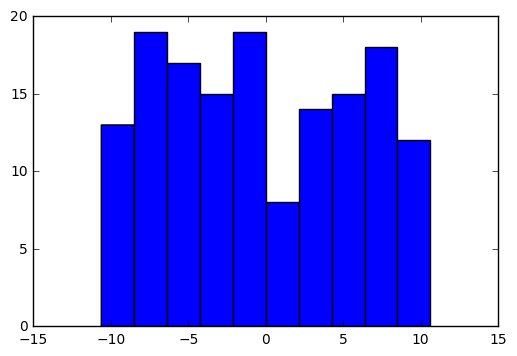

In [33]:
# Central cavity y-based filtering

yc_middles = []

for i, oi_event in enumerate(oi_events):
    
    
    xs = [ellipse[1] for ellipse in ellipsess[i]]
    ys = [ellipse[2] for ellipse in ellipsess[i]]
    
    
    xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)
    xcs = oi_stage.pixels_to_meters(xcs)
    ycs = oi_stage.pixels_to_meters(ycs)
    
    
    is_interp = scipy.interpolate.interp1d(xcs, range(len(xcs)))
    
    
    i_middle = int(is_interp(oi_stage._length_microns/2.))
    
    
    yc_middles.append(ycs[i_middle])
    
    
    
    
# Apply offset to y so centered at 0
offset = -(np.max(yc_middles) - np.abs(np.min(yc_middles)))/2.
yc_middles = np.array(yc_middles)
yc_middles = yc_middles + offset


# Plot hist of all ys
plt.hist(yc_middles)
plt.show()



In [34]:
yc_threshold = 5
filtering_steps.append(['yc cavity threshold', yc_threshold])

keep_indices_y = np.where(np.abs(yc_middles) <= yc_threshold)[0]

print 'length before', len(oi_events), 'length after', len(keep_indices_y)

length before 150 length after 66


In [24]:
oi_index = 12
print effective_radii[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf).to_html5_video())

9.85282927124


## Manual filtering

In [35]:
manual_remove_indices = []

filtering_steps.append(['manual removal (num events manually removed)', len(remove_indices)])

keep_indices_manual = [i for i in range(len(oi_events)) if i not in remove_indices]

## Filtering step

In [43]:
keep_indices = [i for i in range(len(oi_events)) if ((i in keep_indices_radius)\
                                                     and (i in keep_indices_aspect)\
                                                     and (i in keep_indices_y)\
                                                    and (i in keep_indices_manual))]


print(keep_indices)
print('filtering ' + str(len(oi_events) - len(keep_indices)) + ' out of ' + str(len(oi_events)) + ' events')

[0, 9, 12, 20, 23, 27, 28, 45, 46, 48, 51, 52, 54, 57, 65, 66, 67, 74, 75, 78, 82, 83, 84, 88, 91, 96, 99, 104, 105, 108, 109, 113, 115, 130, 138]
filtering 115 out of 150 events


In [46]:
oi_events_filtered = [oi_events[i] for i in keep_indices]

# Save

### Save filtering parameters

In [47]:
output_file_path = '../data/' + date + particle + channel + 'filter_parameters_' + file_index
print output_file_path


with open(output_file_path, 'w') as file_handle:
    file_writer = csv.writer(file_handle, delimiter = '\t')
    
    
    # Write filtering steps
    for filtering_step in filtering_steps:
        print filtering_step
        file_writer.writerow(filtering_step)

../data/7-17-2017/293-T/15-30-15_1/filter_parameters_0


### Save filtered events

In [48]:
oi_events_output_file_path = oi_events_file_path.replace('.json', '_filtered.json')
oi_file.save_oi_events_json(oi_events_output_file_path, oi_events_filtered)